In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
is_cuda=False
if torch.cuda.is_available():
    is_cuda = True

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST('data/',train=True,transform=transformation,download=True)
test_dataset = datasets.MNIST('data/',train=False,transform=transformation,download=True)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=True)

Processing...
Done!


In [4]:
sample_data = next(iter(train_loader))

In [33]:
def plot_raw_img(image):
    image = image.numpy()[0]
    plt.imshow(image,cmap='gray')

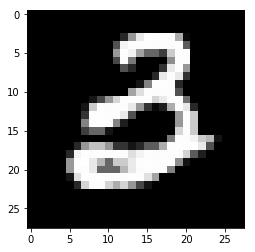

In [35]:
plot_raw_img(sample_data[0][0])

In [5]:
def plot_img(image):
    image = image.numpy()[0]
    mean = 0.1307
    std = 0.3081
    image = ((mean * image) + std)
    plt.imshow(image,cmap='gray')

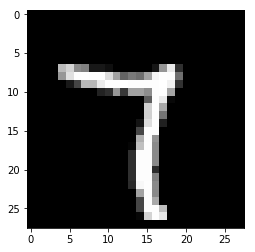

In [6]:
plot_img(sample_data[0][2])

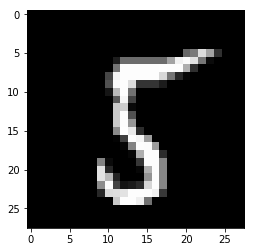

In [7]:
plot_img(sample_data[0][1])

In [36]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #flatten to 1D
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x,p=0.1, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

In [37]:
model = Net()
if is_cuda:
    model.to(device)

In [38]:
optimizer = optim.SGD(model.parameters(),lr=0.01)

In [39]:
data , target = next(iter(train_loader))

In [40]:
output = model(Variable(data.cuda()))

In [41]:
output.size()

torch.Size([32, 10])

In [42]:
target.size()

torch.Size([32])

In [43]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.to(device),target.to(device)
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output,target)
        
        running_loss += F.nll_loss(output,target,size_average=False).item()
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = float(running_loss/len(data_loader.dataset))
    accuracy = float(100. * running_correct/len(data_loader.dataset))
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [44]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,20):
    epoch_loss, epoch_accuracy = fit(epoch,model,train_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,test_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

/home/walle/miniconda3/envs/pytorch1_py37/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is  0.69 and training accuracy is 46617/60000      77.0
validation loss is  0.17 and validation accuracy is 9491/10000      94.0
training loss is  0.23 and training accuracy is 55913/60000      93.0
validation loss is 0.096 and validation accuracy is 9714/10000      97.0
training loss is  0.17 and training accuracy is 56796/60000      94.0
validation loss is 0.072 and validation accuracy is 9766/10000      97.0
training loss is  0.15 and training accuracy is 57235/60000      95.0
validation loss is 0.061 and validation accuracy is 9804/10000      98.0
training loss is  0.13 and training accuracy is 57630/60000      96.0
validation loss is 0.058 and validation accuracy is 9819/10000      98.0
training loss is  0.12 and training accuracy is 57935/60000      96.0
validation loss is 0.053 and validation accuracy is 9837/10000      98.0
training loss is  0.11 and training accuracy is 58030/60000      96.0
validation loss is 0.049 and validation accuracy is 9850/10000      98.0

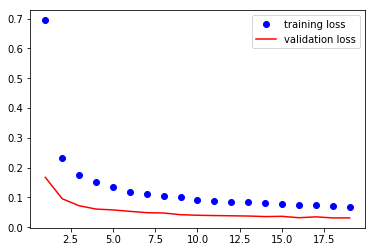

In [45]:
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

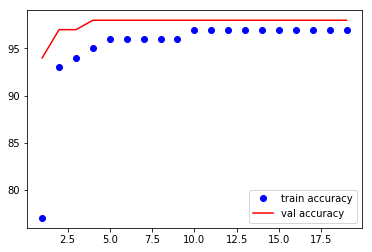

In [46]:
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()

## Understanding 1d convolutions

In [24]:
conv = nn.Conv1d(1,1,3,bias=False)

In [25]:
conv.weight

Parameter containing:
tensor([[[ 0.4462,  0.3800, -0.0685]]], requires_grad=True)

In [26]:
sample = torch.randn(1,1,7)

In [27]:
sample

tensor([[[-0.2793, -0.1777, -2.1444, -0.5578, -0.2056, -0.1106,  1.0211]]])

In [28]:
conv(Variable(sample))

tensor([[[-0.0451, -0.8560, -1.1547, -0.3194, -0.2037]]],
       grad_fn=<SqueezeBackward1>)

### Understand how padding works in Conv1d

In [29]:
conv = nn.Conv1d(1,1,3,padding=2,bias=False)
conv.weight

Parameter containing:
tensor([[[ 0.2845, -0.2264, -0.3130]]], requires_grad=True)

In [30]:
sample = torch.randn(1,1,7)
sample

tensor([[[ 0.4736, -1.3799,  1.2748,  1.0609,  1.0306, -0.8908, -0.7138]]])

In [31]:
conv(Variable(sample))

tensor([[[-0.1482,  0.3247,  0.0481, -1.0132, -0.2000,  0.3474,  0.7183,
          -0.0919, -0.2031]]], grad_fn=<SqueezeBackward1>)